In [45]:
from collections import namedtuple

import requests
import json
import re
import logging

from tqdm.auto import tqdm
from bs4 import BeautifulSoup

from pathlib import Path

project_dir = Path('/home/jovyan/active-projects/keyword-extraction')

with open(project_dir / 'data' / 'textbook-first-pages.txt', 'r') as f:
    textbook_first_pages = f.read().splitlines()

## Class for Scraping OpenStax

We look for all elements that with `data-type` == `'title'`. This includes subsection headers as well as exercise problem titles and information cards.

Ignore exercise problem titles and information cards, which are identified by `id` and `class: ['os-title']`, respectively.

### Assumptions and Shortcuts
 - Ignoring any pages that do not start with digit-dash-digit, so '1-1-introduction' is fine but '1-Introudction' and 'Index' are ignored

### Subsection Header
"Sets of Numbers as Subsets". This is the subsection header that we want.

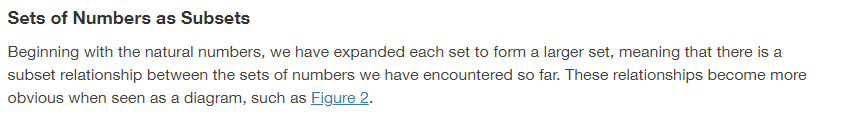

### Exercise problem
The Exercise problem title is "EXAMPLE 5". We do not want to consider this a subsection. We ignore it by looking for titles WITHOUT the `id` tag.

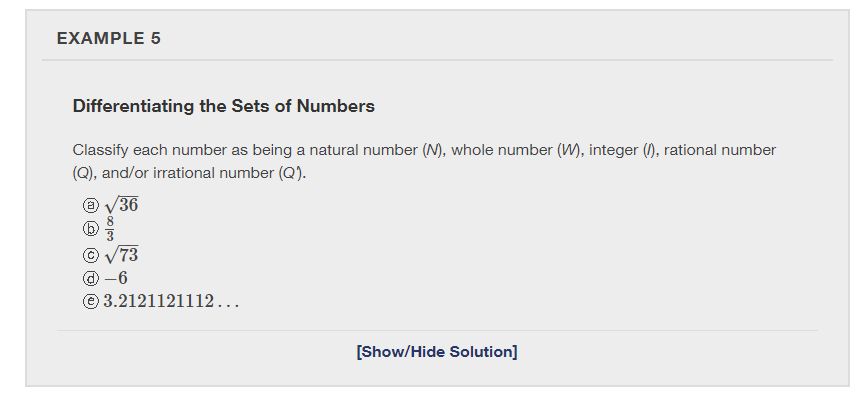

### Information Card
The information card title is "SETS OF NUMBERS". We do not want to consider this a subsection. We ignore it by looking for titles without the `class: ['os-title']` tag.

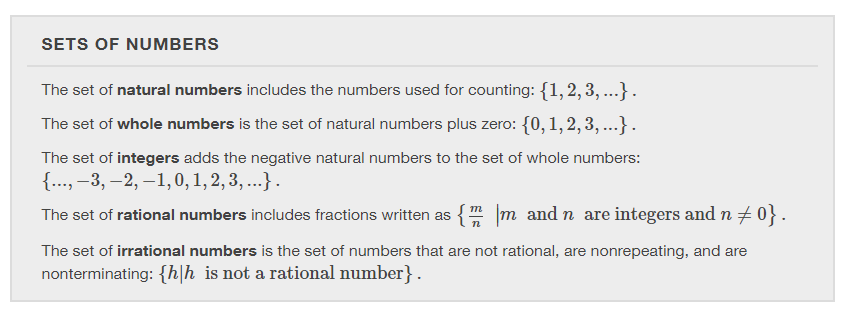


In [41]:
KeyTerm = namedtuple('KeyTerm', ('start', 'end', 'type'))

class StaxBook:
    def __init__(self, first_page_url):
        # e.g. https://openstax.org/books/principles-macroeconomics-2e/pages/1-1-what-is-economics
        self.first_page_url = first_page_url
        
        # e.g. https://openstax.org/books/principles-macroeconomics-2e
        self.base_url = first_page_url.split('/pages/')[0]
        
        # e.g. principles-macroeconomics-2e
        self.title = self.base_url.split('/')[-1]
        
        self.sections = {}
        
        logger.info(f'Getting section urls for {self.title}...')
        self.get_section_urls()
        
    def get_section_urls(self):
        soup = BeautifulSoup(requests.get(self.first_page_url).text,
                             features='html.parser')
        
        for a in soup.find_all('a',
                               class_='styled__ContentLink-sc-18yti3s-1 cRIWDW',
                               href=True):
            
            section_title = a['href']
                
            # matches urls with a chapter-section-title format, like "1-1-what-is-economics"
            # no match for urls with a chapter-title format, like "1-introduction" or "1-keyterms"
            match = re.search(r'^(\d+)-(\d+)', section_title)
            
            if match:               
                self.sections[section_title] = {
                    'chapter': match.group(0),
                    'section': match.group(1),
                    'url': '/'.join([self.base_url, 'pages', section_title]),
                }
        
    def scrape_one(self, soup):
        '''Scrape a textbook section page into a dictionary of subsections.
        '''
        
        # create a list of sub-section headers
        sub_section_headers = list(
            soup.find_all(
                attrs={'data-type': 'title', 'id': None, 'class': None}
                )
            )
                
        # catch any content that appears before the first header
        # by beginning with a 'no_header' subsection
        header = 'no_header'
        section_dict = {header: {'text': '', 'keyterms': []}}

        # keep track of sub_section_str_len
        sub_section_str_len = 0

        for e in soup.strings:
            
            if e.parent in sub_section_headers:
                header = e.text
                section_dict[header] = {'text': '', 'keyterms': []}
                sub_section_str_len = 0
            
            if isinstance(e, str) and not e.isspace():
                # add a space at the end of each element
                text = re.sub('\s+', ' ', e.text) + ' '
                                
                if e.parent.attrs.get('data-type', None) == 'term':
                    
                    term_type = (
                        'light' if e.parent.attrs.get('class', [None])[0]
                        else 'bold'
                        )
                    
                    section_dict[header]['keyterms'].append(
                        KeyTerm(
                            sub_section_str_len,
                            # -1 because we do not want the extra space
                            sub_section_str_len + len(text) - 1,
                            term_type
                            )
                        )
                    
                section_dict[header]['text'] += text
                sub_section_str_len += len(text)
                
        # remove trailing space
        section_dict[header]['text'] = section_dict[header]['text'][:-1]
        
        # remove the 'no_header' subsection if empty
        if not section_dict['no_header']['text']:
            del section_dict['no_header']
        
        return section_dict
                     
    def scrape_all(self):
        logger.info(f'Scraping {self.title}...')
        
        for section in tqdm(self.sections.values(), leave=False):
            
            soup = BeautifulSoup(
                requests.get(section['url']).content.decode('utf-8'),
                features='html5lib'
                ).find('div', id='main-content')
            
            section['subsections'] = self.scrape_one(soup)

In [ ]:
logging.basicConfig(level=logging.INFO)

logger = logging.getLogger('scaper')

stax_books = [StaxBook(url) for url in tqdm(textbook_first_pages, total=len(textbook_first_pages))]

In [ ]:
for book in tqdm(stax_books, total=len(stax_books)):
    book.scrape_all()

In [46]:
import json

library = {book.title: book.sections for book in stax_books}
with open(project_dir / 'data' / 'openstax-subsections.json', 'w') as f:
    json.dump(library, f, indent=4)

# Descriptives

|                            |           value |
|:---------------------------|----------------:|
| num_books                  |              50 |
| num_sections               |           4,831 |
| num_subsections            |          30,561 |
| mean_num_subsections       |               6 |
| total_word_count           |      14,472,600 |
| mean_word_count_section    |           2,996 |
| mean_word_count_subsection |             474 |
| num_bold_keyterms          |          27,461 |
| num_light_keyterms         |          18,808 |
| total_keyterms             |          46,269 |
| mean_bold_keyterms         |               6 |
| mean_light_keyterms        |               4 |
| mean_total_keyterms        |              10 |

In [94]:
with open(project_dir / 'data' / 'openstax-subsections.json', 'r') as f:
    library = json.load(f)

descriptives = {
    'num_books': len(library),
    'num_sections': sum(len(book) for book in library.values()),
    'num_subsections': sum(len(section['subsections']) for book in library.values() for section in book.values()),
    'total_word_count': sum(len(subsection['text'].split()) for book in library.values() for section in book.values() for subsection in section['subsections'].values()),
}
descriptives['mean_num_subsections'] = round(descriptives['num_subsections'] / descriptives['num_sections'])
descriptives['mean_word_count_section'] = round(descriptives['total_word_count'] / descriptives['num_sections'])
descriptives['mean_word_count_subsection'] = round(descriptives['total_word_count'] / descriptives['num_subsections'])
descriptives['num_bold_keyterms'] = sum((keyterm[2] == 'bold') for book in library.values() for section in book.values() for subsection in section['subsections'].values() for keyterm in subsection['keyterms'])
descriptives['num_light_keyterms'] = sum((keyterm[2] == 'light') for book in library.values() for section in book.values() for subsection in section['subsections'].values() for keyterm in subsection['keyterms'])
descriptives['total_keyterms'] = descriptives['num_bold_keyterms'] + descriptives['num_light_keyterms']
# keyterm means are per section
descriptives['mean_bold_keyterms'] = round(descriptives['num_bold_keyterms'] / descriptives['num_sections'])
descriptives['mean_light_keyterms'] = round(descriptives['num_light_keyterms'] / descriptives['num_sections'])
descriptives['mean_total_keyterms'] = round(descriptives['total_keyterms'] / descriptives['num_sections'])
print(pd.DataFrame.from_dict(descriptives, orient='index', columns=['value']).to_markdown())

|                            |           value |
|:---------------------------|----------------:|
| num_books                  |    50           |
| num_sections               |  4831           |
| num_subsections            | 30561           |
| total_word_count           |     1.44726e+07 |
| mean_num_subsections       |     6           |
| mean_word_count_section    |  2996           |
| mean_word_count_subsection |   474           |
| num_bold_keyterms          | 27461           |
| num_light_keyterms         | 18808           |
| total_keyterms             | 46269           |
| mean_bold_keyterms         |     6           |
| mean_light_keyterms        |     4           |
| mean_total_keyterms        |    10           |


# To SpaCy DocBin

In [73]:
import spacy
nlp = spacy.blank('en')

from spacy.tokens import Doc, DocBin

for extension in ['section_url', 'subsection']:
    if not Doc.has_extension(extension):
        Doc.set_extension(extension, default=None)

def subsection_generator(library):
    for book in library.values():
        for section in book.values():
            for title, subsection in section['subsections'].items():
                yield section['url'], title, subsection    

In [91]:
def refine_span(doc, st, end, label):
    '''SpaCy sequence labels cannot have leading or trailing whitespace
    or cross token boundaries.
    Shrinks sequences and update their indices.
    If a label crosses a token boundary, msg the problem 
    and shrink the sequence to the nearest token boundary.
    '''
    
    # terms like "y-axis" were scraped as " -axis".
    # move the start back to cover the "y " or the "trans" in "trans -fat"
    # do not worry about the space...
    if doc.text[st] == '-':
        st -= 2 # move start back to cover whitespace
        while not doc.text[st-1].isspace():
            st -= 1
            
    orig_sequence = doc.text[st:end]
    
    # regex to match word characters
    just_word_characters = re.compile(r'\w+')
    
    # matches longest sequence that starts and ends with a letter, number, or allowed punctuation
    # allowed punctuation is rounded quotation marks, straight quotation marks, and round brackets.
    no_leading_trailing_space_or_punct = re.compile(r'[\(\w\"\“].*[\w\"\”\)]')
    
    if (match := re.search(no_leading_trailing_space_or_punct, orig_sequence)):
        new_sequence = match[0]
    elif (match:= re.search(just_word_characters, orig_sequence)):
        new_sequence = match[0]
    else:
        logging.warning(f'No valid sequence found for "{orig_sequence}" in {doc._.section_url}')
        return

    if new_sequence != orig_sequence:
        st = st + match.start() # offset start ind by match start
        end = end - (len(orig_sequence) - match.end()) # offset end index by (old string length - new string length)        
        logging.info(f'Sequence "{orig_sequence}" transformed to "{new_sequence}" at [{st}, {end}]')
    
    span = doc.char_span(st, end, label=label, alignment_mode='strict')
    
    # try expanding the span
    if span is None:
        logging.info(f'Sequence [{st}, {end}] does not align with token boundaries.\nOriginal sequence was "{orig_sequence}"')
        span = doc.char_span(st, end, label=label, alignment_mode='expand')
        if span:
            logging.info(f'Setting sequence as "{span}" at [{span.start_char}, {span.end_char}]')
        else:
            logging.warning(f'Failed to create span in {doc._.section_url}')
            return
    
    # If all our checks fail to get rid of leading/trailing whitespace, discard the span...
    if span[0].is_space or span[-1].is_space:
        logging.warning(f'Leading or Trailing whitespace still remains in "{span}" in {doc._.section_url}')
        return
    
    return span

In [92]:
db = DocBin(store_user_data=True)
for section_url, title, subsection in tqdm(subsection_generator(library), total=descriptives['num_subsections']):
    doc = nlp(subsection['text'])
    doc._.section_url = section_url
    doc._.subsection = title
    keyterm_spans = [refine_span(doc, *keyterm) for keyterm in subsection['keyterms']]
    doc.ents = spacy.util.filter_spans(
        [span for span in keyterm_spans if span is not None]
    )
    db.add(doc)

  0%|          | 0/30561 [00:00<?, ?it/s]

INFO:root:Sequence "principal " transformed to "principal" at [434, 443]
INFO:root:Sequence "principal " transformed to "principal" at [846, 855]
INFO:root:Sequence " factorial" transformed to "factorial" at [773, 782]
INFO:root:Sequence "binomial coefficient " transformed to "binomial coefficient" at [760, 780]
INFO:root:Sequence "complement of an event " transformed to "complement of an event" at [1049, 1071]
INFO:root:Sequence "increasing on the interval " transformed to "increasing on the interval" at [7695, 7721]
INFO:root:Sequence "decreasing on the interval " transformed to "decreasing on the interval" at [8063, 8089]
INFO:root:Sequence "symmetry about the " transformed to "symmetry about the" at [467, 485]
INFO:root:Sequence "periodic functions." transformed to "periodic functions" at [542, 560]
INFO:root:Sequence "number " transformed to "number" at [2317, 2323]
INFO:root:Sequence "differentiable at " transformed to "differentiable at" at [562, 579]
INFO:root:Sequence "differe

In [93]:
db.to_disk(project_dir / 'data' / 'openstax-subsections.spacy')